# Sentiment Analisys using BERT
https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

In [223]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb 
import matplotlib.pyplot as plt
from tensorflow import keras


### import the dataset

In [224]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

df = df[:1000]

In [225]:
df.count

<bound method DataFrame.count of                                                      0  1
0    a stirring , funny and finally transporting re...  1
1    apparently reassembled from the cutting room f...  0
2    they presume their audience wo n't sit still f...  0
3    this is a visually stunning rumination on love...  1
4    jonathan parker 's bartleby should have been t...  1
..                                                 ... ..
995  instead of letting the laughs come as they may...  0
996  this tuxedo should have been sent back to the ...  0
997  ever see one of those comedies that just seem ...  0
998  the film is impressive for the sights and soun...  1
999  for most of its footage , the new thriller pro...  1

[1000 rows x 2 columns]>

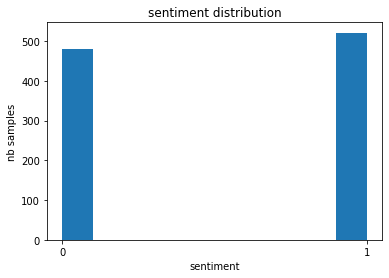

In [226]:
labels = df[1]
plt.hist(labels)
plt.xlabel('sentiment')
plt.ylabel('nb samples')
plt.title('sentiment distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Loading the Pre-trained BERT model

In [227]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.TFDistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.TFBertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### Tokenization

In [228]:
def tokenize(sentences):
    tokenized = [tokenizer(sentence, add_special_tokens=True)['input_ids'] for sentence in sentences]
    return tokenized


In [229]:
tokenized = tokenize(df[0])

In [230]:
print("sentence: ", df[0][0] )
print("tokenized: ", tokenized[0])
print("decoded: ", tokenizer.decode(tokenized[0]))


sentence:  a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
tokenized:  [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102]
decoded:  [CLS] a stirring, funny and finally transporting re imagining of beauty and the beast and 1930s horror films [SEP]


### Padding

In [231]:
def get_max_length(tokens):
    max_len = 0
    for i in tokens:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

In [232]:
max_len = get_max_length(tokenized)
print("Max sentence legth is ", max_len)

Max sentence legth is  59


In [233]:
def pad_tokens(tokens, max_len):
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokens])
    return padded

In [234]:
padded = pad_tokens(tokenized, max_len)

In [235]:
print(padded[0])

[  101  1037 18385  1010  6057  1998  2633 18276  2128 16603  1997  5053
  1998  1996  6841  1998  5687  5469  3152   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]


In [236]:
print("shape of padded: ", padded.shape)

shape of padded:  (1000, 59)


### Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input.

In [237]:
def get_attention_mask(tokens):
    attention_mask = np.where(tokens != 0, 1, 0)    
    return attention_mask

In [238]:
attention_mask = get_attention_mask(padded)
print(attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Create input tensors (putting all together)

In [239]:
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)



The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [240]:

last_hidden_states = model(input_ids, attention_mask = attention_mask)

In [241]:
print("tensor shape (n_samples, max_len, hidden_units): "), last_hidden_states[0].shape


tensor shape (n_samples, max_len, hidden_units): 


(None, TensorShape([1000, 59, 768]))

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

In [242]:
features = last_hidden_states[0][:,0,:].numpy()

## if you use BERT instead of distilBERT model, uncomment this
#features = last_hidden_states[1].numpy() 


In [243]:
features.shape

(1000, 768)

### Labels


In [244]:
lables = df[1].to_numpy()

### Train/Test Split

In [245]:
# 80% train, 20% test
split_size = int(features.shape[0] * .8)    
X_train = features[:split_size,:]
Y_train = lables[:split_size]
X_test = features[split_size:,:]
Y_test = lables[split_size:]

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of test data: ", X_test.shape, Y_test.shape)

shapes of training data:  (800, 768) (800,)
shapes of test data:  (200, 768) (200,)


### Create the Logistic Regression Model

In [246]:
def create_model(input_shape, classes):
    inputs = keras.Input(shape=input_shape, name='input')
    #h1 = keras.layers.Dense(1024, activation='relu', name='h1')(inputs)    
    #h2 = keras.layers.Dense(512, activation='relu', name='h2')(h1)
    #h3 = keras.layers.Dense(32, activation='relu', name='h3')(h2)
    d1 = keras.layers.Dropout(0.1, name='d1')(inputs)
    outputs = keras.layers.Dense(classes, activation='sigmoid', name='output')(d1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['binary_accuracy']
    )

    return model

In [247]:
lr_model = create_model(X_train.shape[1], 1)
lr_model.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
d1 (Dropout)                 (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [248]:
history = lr_model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
5/5 [==============================] - 0s 25ms/step - loss: 0.7402 - binary_accuracy: 0.5156 - val_loss: 0.7041 - val_binary_accuracy: 0.5125
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.6891 - binary_accuracy: 0.5594 - val_loss: 0.7023 - val_binary_accuracy: 0.5125
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6823 - binary_accuracy: 0.5547 - val_loss: 0.6947 - val_binary_accuracy: 0.5625
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6717 - binary_accuracy: 0.5875 - val_loss: 0.6756 - val_binary_accuracy: 0.6000
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6507 - binary_accuracy: 0.6250 - val_loss: 0.6580 - val_binary_accuracy: 0.6187
Epoch 6/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6462 - binary_accuracy: 0.6344 - val_loss: 0.6462 - val_binary_accuracy: 0.6562
Epoch 7/100
5/5 [==============================] - 0s 5ms/step - loss: 0.6418 - b

In [249]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
95,0.389893,0.829687,0.433951,0.80000,95
96,0.394283,0.829687,0.433499,0.80000,96
97,0.395493,0.834375,0.433605,0.79375,97
98,0.388576,0.831250,0.433109,0.79375,98
99,0.388046,0.837500,0.432329,0.80000,99


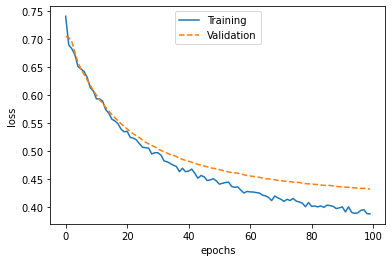

In [250]:
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim([0, 100])
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')
plt.legend(loc='upper center', shadow=False)

### Model Evaluation

In [251]:
lr_model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 984us/step - loss: 0.3980 - binary_accuracy: 0.8750


[0.3980494439601898, 0.875]

### Inference

In [252]:

sentences = ["I'm happy to be here", "i got scared", "i'm sick", "today is a beautiful day"]

tokenized = tokenize(sentences)
padded = pad_tokens(tokenized, max_len)
attention_mask = get_attention_mask(padded)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)

last_hidden_states = model(input_ids, attention_mask = attention_mask)

features = last_hidden_states[0][:,0,:].numpy()

lr_model.predict(features) > .5

array([[ True],
       [False],
       [False],
       [ True]])